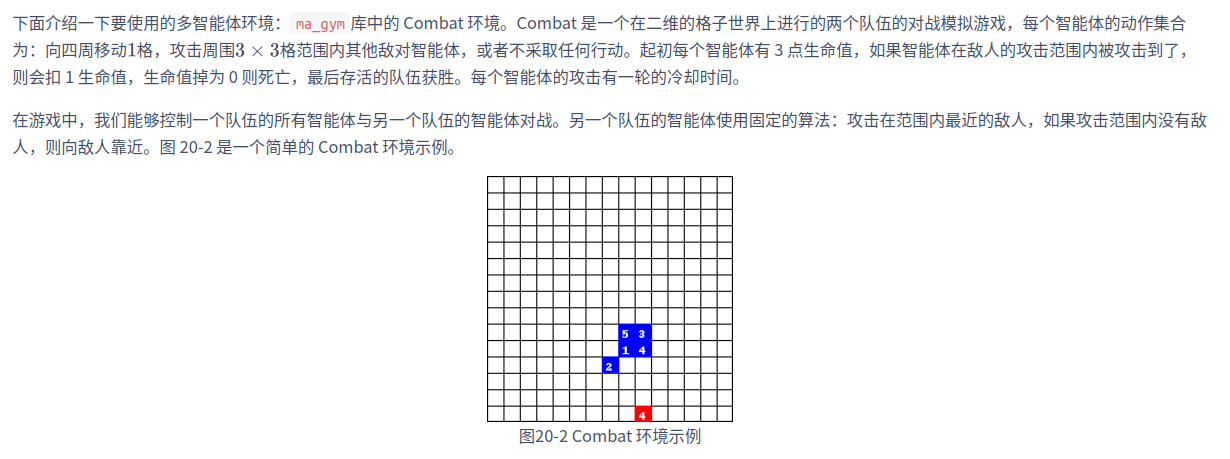

In [10]:
from game_env.game.Combat import Combat

# 测试环境是否可用，已修复完毕
def run_combat_demo():
    """运行 Combat 环境演示"""
    
    # 创建 Combat 环境
    env = Combat(
        grid_shape=(15, 15),
        n_agents=2,
        n_opponents=2,
        init_health=3,
        max_steps=100,
        render_mode="human"  # 设置为 "rgb_array" 可禁用图形界面
    )
    
    print("Combat 环境创建成功!")
    print(f"智能体数量: {env.n_agents}")
    print(f"对手数量: {env._n_opponents}")
    print(f"网格大小: {env._grid_shape}")
    
    # 重置环境
    observations, info = env.reset()
    print("环境重置成功!")
    
    # 修复：使用 len() 而不是 .shape
    print(f"观察空间长度: {[len(obs) for obs in observations]}")
    
    # 运行几个回合
    for episode in range(3):
        print(f"\n=== 第 {episode + 1} 回合 ===")
        
        observations, info = env.reset()
        
        step = 0
        done = False
        
        while not done and step < 50:  # 限制步数用于演示
            # 随机动作
            actions = [env.action_space[i].sample() for i in range(env.n_agents)]
            
            # 执行动作
            observations, rewards, terminated, truncated, info = env.step(actions)
            
            # 渲染环境
            if env.render_mode == "human":
                env.render()
            
            # 显示奖励
            for i, reward in enumerate(rewards):
                if reward != 0:
                    print(f"步骤 {step}: 智能体 {i} 获得奖励 {reward}")
            
            step += 1
            done = terminated or truncated
            
            if done:
                if terminated:
                    print("游戏结束!")
                    if all(h > 0 for h in info['agent_health'].values()):
                        print("红队胜利!")
                    else:
                        print("蓝队胜利!")
                else:
                    print("达到最大步数!")
    
    # 关闭环境
    env.close()
    print("演示完成!")

# run_combat_demo()

In [11]:
# 检查版本
import pettingzoo
print("PettingZoo 版本:", pettingzoo.__version__)

# 检查可用的环境
from pettingzoo import utils
print("可用环境:", [name for name in dir(pettingzoo) if not name.startswith('_')])


PettingZoo 版本: 1.25.0
可用环境: ['AECEnv', 'ParallelEnv', 'notifications', 'os', 'sys', 'utils']


In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import rl_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

# ! git clone https://github.com/boyu-ai/ma-gym.git
# import sys
# sys.path.append("./ma-gym")
# from ma_gym.envs.combat.combat import Combat

# ma_gym过期了，使用新的库代替
# sudo apt-get update
# sudo apt-get install swig
# pip install "pettingzoo[all]"


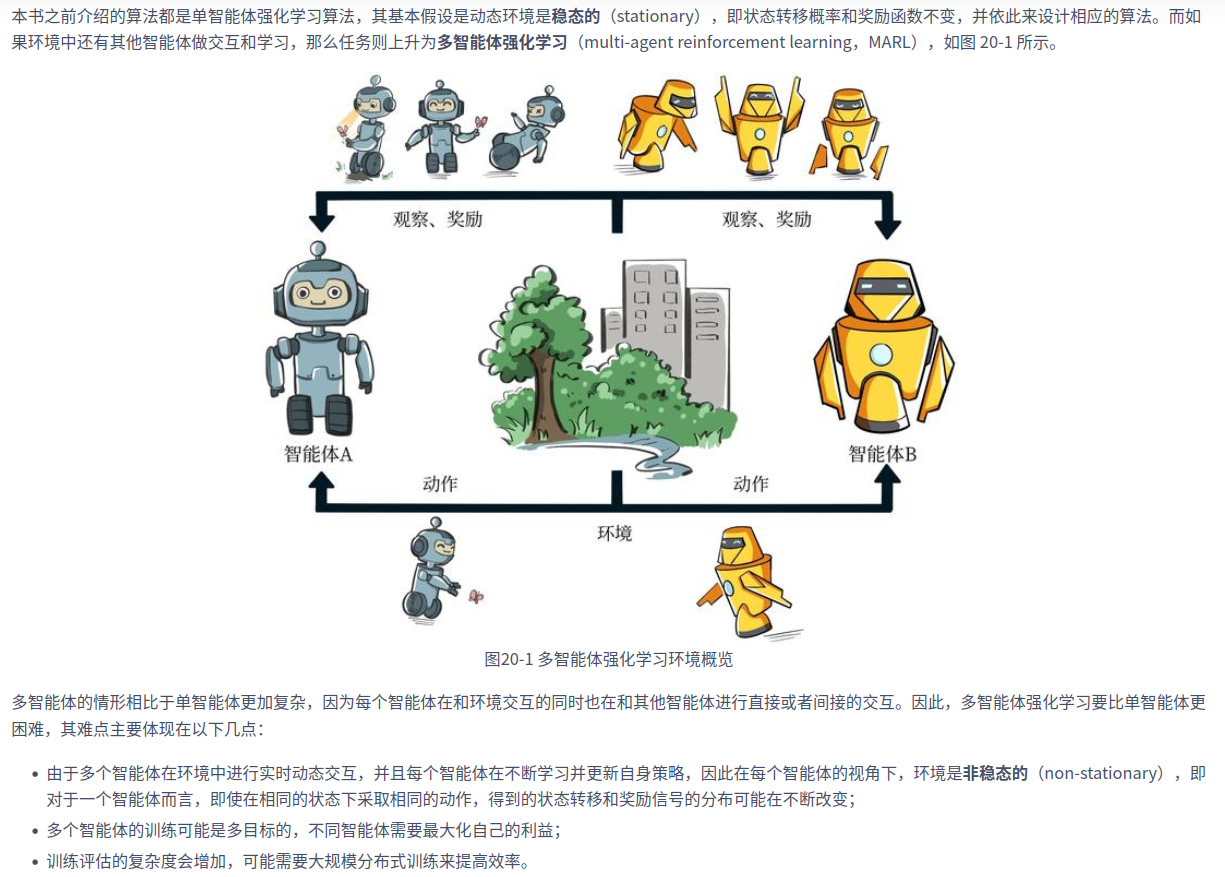  
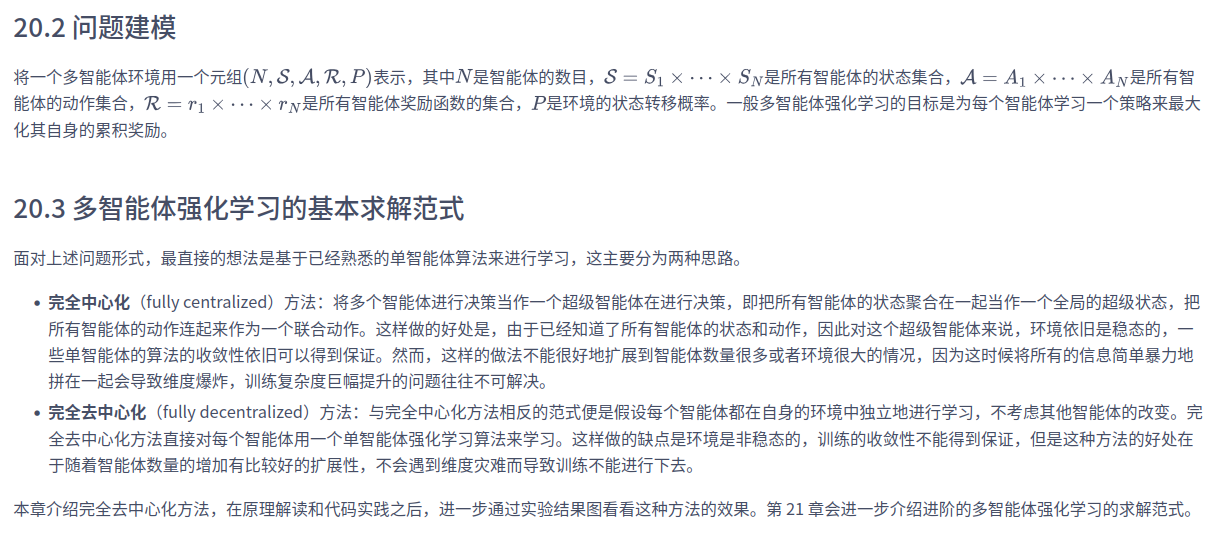  
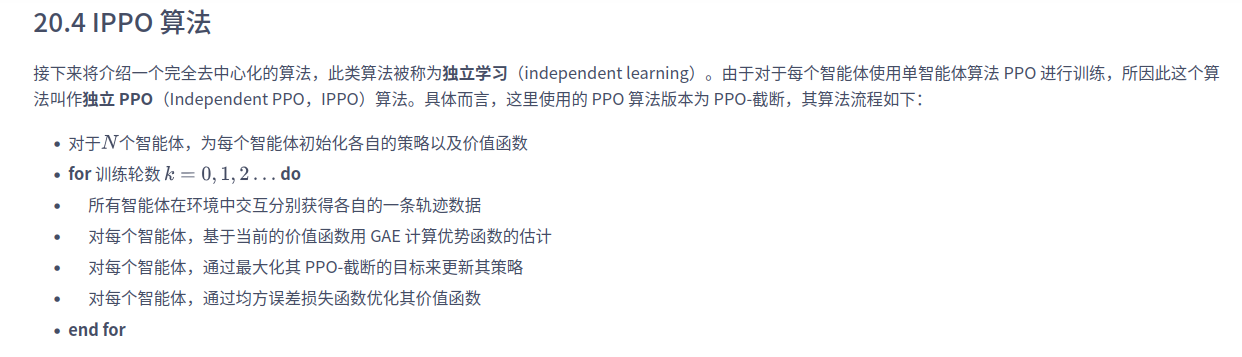  

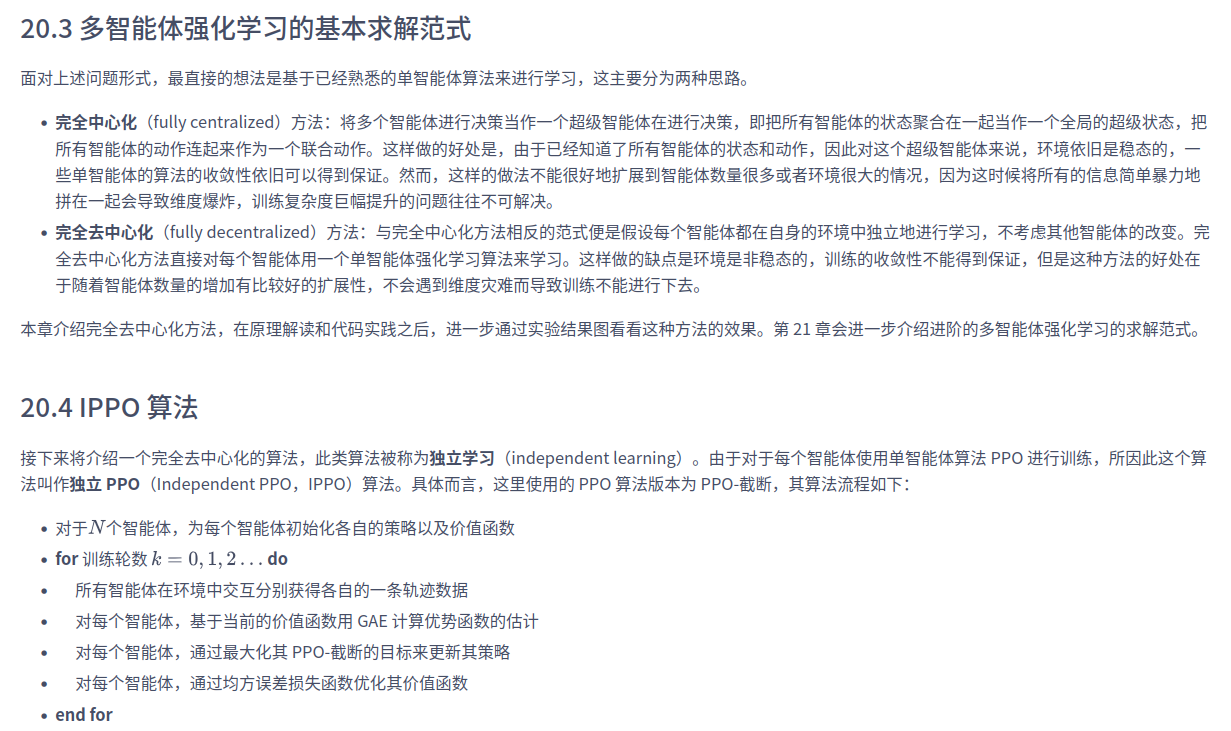

In [13]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return F.softmax(self.fc3(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        log_probs = torch.log(self.actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1 - self.eps,
                            1 + self.eps) * advantage  # 截断
        actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

现在进入 IPPO 代码实践的最主要部分。值得注意的是，在训练时使用了参数共享（parameter sharing）的技巧，即对于所有智能体使用同一套策略参数，  
这样做的好处是能够使得模型训练数据更多，同时训练更稳定。能够这样做的前提是，两个智能体是同质的（homogeneous），  
即它们的状态空间和动作空间是完全一致的，并且它们的优化目标也完全一致。  
感兴趣的读者也可以自行实现非参数共享版本的 IPPO，此时每个智能体就是一个独立的 PPO 的实例。

和之前的一些实验不同，这里不再展示智能体获得的回报，而是将 IPPO 训练的两个智能体团队的胜率作为主要的实验结果。接下来就可以开始训练 IPPO 了！

In [14]:
actor_lr = 3e-4
critic_lr = 1e-3
num_episodes = 10000
hidden_dim = 64
gamma = 0.99
lmbda = 0.97
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

team_size = 2
grid_size = (15, 15)
#创建Combat环境，格子世界的大小为15x15，己方智能体和敌方智能体数量都为2
env = Combat(grid_shape=grid_size, n_agents=team_size, n_opponents=team_size)
env.reset(seed=0)
state_dim = env.observation_space[0].shape[0]
action_dim = env.action_space[0].n
#两个智能体共享同一个策略
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, eps,
            gamma, device)



In [15]:
win_list = []
episode_rewards = []

for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            # 为每个智能体创建经验缓冲区
            transition_dicts = [
                {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                for _ in range(team_size)
            ]
            
            # 重置环境
            observations, info = env.reset()
            terminated = False
            truncated = False
            episode_reward = 0
            
            # 运行一个回合
            while not terminated and not truncated:
                # 获取动作
                actions = [agent.take_action(obs) for obs in observations]
                
                # 执行动作
                next_observations, rewards, terminated, truncated, info = env.step(actions)
                
                # 存储经验
                for j in range(team_size):
                    transition_dicts[j]['states'].append(observations[j])
                    transition_dicts[j]['actions'].append(actions[j])
                    transition_dicts[j]['next_states'].append(next_observations[j])
                    transition_dicts[j]['rewards'].append(rewards[j])  # 暂时不修改奖励
                    transition_dicts[j]['dones'].append(terminated or truncated)
                
                observations = next_observations
                episode_reward += sum(rewards)
            
            # 回合结束后，根据胜负修改最终奖励
            if terminated:
                if info.get('win', False):
                    # 胜利：给最后一个步骤添加额外奖励
                    for j in range(team_size):
                        if transition_dicts[j]['rewards']:
                            transition_dicts[j]['rewards'][-1] += 100
                else:
                    # 失败：给最后一个步骤添加惩罚
                    for j in range(team_size):
                        if transition_dicts[j]['rewards']:
                            transition_dicts[j]['rewards'][-1] -= 100
            
            # 记录胜负
            win_list.append(1 if info.get('win', False) else 0)
            episode_rewards.append(episode_reward)
            
            # 更新策略
            for j in range(team_size):
                agent.update(transition_dicts[j])
            
            # 更新进度条
            if (i_episode + 1) % 100 == 0:
                win_rate = np.mean(win_list[-100:]) if len(win_list) > 0 else 0
                avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) > 0 else 0
                pbar.set_postfix({
                    'episode': f'{(num_episodes / 10 * i + i_episode + 1):.0f}',
                    'win_rate': f'{win_rate:.3f}',
                    'avg_reward': f'{avg_reward:.3f}'
                })
            pbar.update(1)

# 关闭环境
env.close()
print("训练完成!")

Iteration 9: 100%|██████████| 1000/1000 [00:53<00:00, 18.66it/s, episode=10000, win_rate=0.000, avg_reward=-1.710]

训练完成!


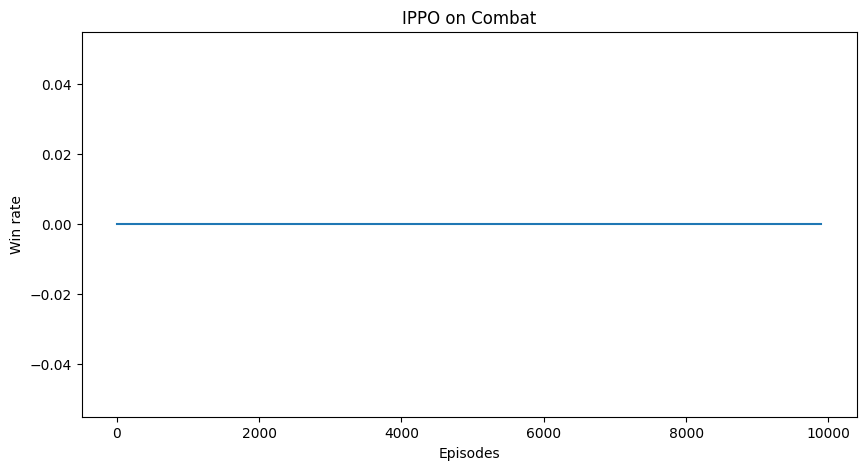

最终胜率: 0.0%


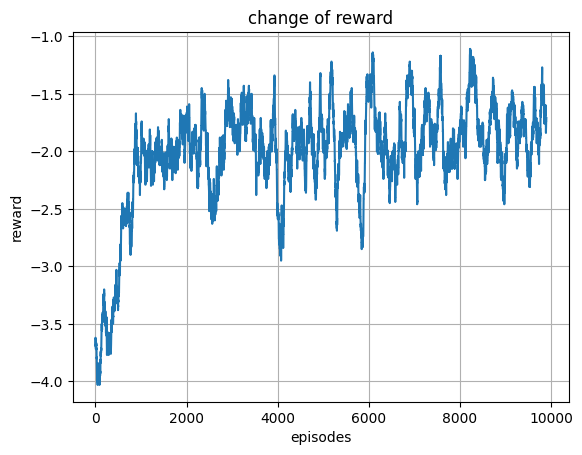

In [17]:

win_array = np.array(win_list)
win_rates = np.mean(win_array.reshape(-1, 100), axis=1) * 100
# #每100条轨迹取一次平均
episodes = np.arange(win_rates.shape[0]) * 100

plt.figure(figsize=(10, 5))
plt.plot(episodes, win_rates)
plt.xlabel('Episodes')
plt.ylabel('Win rate')
plt.title('IPPO on Combat')
plt.show()


print(f"最终胜率: {win_rates[-1]:.1f}%")

# 最简奖励可视化（一行代码）
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'))
plt.title('change of reward')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.grid(True)
plt.show()

可以看出，当智能体数量较少的时候，IPPO 这种完全去中心化学习在一定程度上能够取得好的效果，但是最终达到的胜率也比较有限。这可能是因为多个智能体之间无法有效地通过合作来共同完成目标。同时，好奇的读者也可以尝试增加智能体的数量，比较一下训练结果。当数量增加到 5 时，这种完全去中心化学习的训练效果就不是很好了。这时候可能就需要引入更多的算法来考虑多个智能体之间的交互行为，或者使用中心化训练去中心化执行（centralized training with decentralized execution，CTDE）的范式来进行多智能体训练，该方法将在第 21 章中详细介绍。

本章介绍了多智能体强化学习的概念和两类基本的解决范式，并针对其中的完全去中心化方法进行了详细的介绍，讲解了一个具体的算法 IPPO，即用 PPO 算法为各个智能体训练各自的策略。在 Combat 环境中，我们共享了两个智能体之间的策略，以达到更好的效果。但这仅限于多个智能体同质的情况，若它们的状态空间或动作空间不一致，那便无法进行策略共享。